<h2> CNN w. dataloader

In [19]:
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data
import torch
import pandas as pd
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

class SkeletonData(data.Dataset):
    def __init__(self):

        train = pd.read_csv(r"C:\Users\sofu0\OneDrive - ITU\Bachelor\kfold\fold0\sub_folder0\train.csv")

        train["finals"][train["finals"]=="idle"] = 0
        train["finals"][train["finals"]=="take-off"] = 1
        train["finals"][train["finals"]=="skill"] = 2
        train["finals"][train["finals"]=="landing"] = 3

        print(train["finals"])

        train_labels = train['finals'].values

        train = train.drop(["clipname", "videoname","finals"],axis=1).values.reshape(len(train), 1, 2, 33)


        self.datalist = train
        self.labels = train_labels
    def __getitem__(self, index):
        return torch.Tensor(self.datalist[index].astype(float)), self.labels[index]
    def __len__(self):
        return self.datalist.shape[0]

# train_Set = SkeletonData()
# trainloader = torch.utils.data.DataLoader( dataset = train_Set , batch_size= 64 , shuffle = True)


dataset = SkeletonData()
batch_size = 64
validation_split = .2
shuffle_dataset = False
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

0        3
1        3
2        0
3        3
4        3
        ..
36535    3
36536    1
36537    1
36538    3
36539    1
Name: finals, Length: 36540, dtype: object


C:\Users\sofu0\AppData\Local\Temp\ipykernel_12576\1082258407.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["finals"][train["finals"]=="idle"] = 0
C:\Users\sofu0\AppData\Local\Temp\ipykernel_12576\1082258407.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["finals"][train["finals"]=="take-off"] = 1
C:\Users\sofu0\AppData\Local\Temp\ipykernel_12576\1082258407.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tra

In [ ]:
print("hello ")

In [3]:

from kfoldCNN.CNN import CNN

In [4]:
model = CNN()
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.8)
optimizer = optim.SGD(model.parameters(), lr=0.02919, momentum=0.845)
# optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.8)

from torch.autograd import Variable
for epoch in range(2):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        # print(i)
        images = Variable(images)
        labels = Variable(labels)

        optimizer.zero_grad()
        # print(images.shape)
        outputs = model(images)
        # print(labels)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

[1,   100] loss: 0.060
[1,   200] loss: 0.047
[1,   300] loss: 0.041
[1,   400] loss: 0.040
[2,   100] loss: 0.038
[2,   200] loss: 0.036
[2,   300] loss: 0.037
[2,   400] loss: 0.037


In [7]:
preds, y = check_accuracy(validation_loader, model)

from sklearn.metrics import f1_score, accuracy_score
print(accuracy_score(y, preds))
print(f1_score(y, preds, average='macro'))

0.6947181171319102
0.6364153424827623


In [7]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    pred_list = []
    y_list = []
    for i,(x, y) in enumerate(loader):


        scores = model(x)
        _, predictions = scores.max(1)

        # print(predictions)
        # print("---")
        # num_correct += (predictions == y).sum()
        # num_samples += predictions.size(0)

        pred_list+=predictions.tolist()
        y_list+=y.tolist()


    return pred_list, y_list




<h2> Save Model

In [8]:
path = r"C:\Users\sofu0\OneDrive - ITU\Bachelor\models\CNN\test_test_model"
torch.save(model, path)
model.eval

<bound method Module.eval of CNN(
  (conv1): Conv2d(1, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=576, out_features=4, bias=True)
)>

In [9]:
o = torch.load(path)

preds, y = check_accuracy(validation_loader, o)

from sklearn.metrics import f1_score, accuracy_score
print(accuracy_score(y, preds))
print(f1_score(y, preds, average='macro'))

0.6947181171319102
0.6364153424827623


In [10]:
path = r"C:\Users\sofu0\OneDrive - ITU\Bachelor\kfold\fold0\batman_model"

o = torch.load(path)

preds, y = check_accuracy(validation_loader, o)

from sklearn.metrics import f1_score, accuracy_score
print(accuracy_score(y, preds))
print(f1_score(y, preds, average='macro'))

ModuleNotFoundError: No module named 'CNN'

<h2> Compare with SKlearn

In [10]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# df = pd.read_csv(r'C:\Users\sofu0\OneDrive - ITU\Bachelor\all_skeleton\all_skeleton_preprocessed_v2.csv')
# df = df.sample(3600)
# y = df["finals"]
# X = df.drop(columns=(["finals", "videoname", "clipname"]), axis=1)
#
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)
#
# clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
#
# clf.predict_proba(X_test[:1])
# clf.score(X_test, y_test)

In [13]:

# path = r"C:\Users\sofu0\OneDrive - ITU\Bachelor\kfold\fold0"
path = r"C:\Users\sofu0\OneDrive - ITU\Bachelor\kfold\fold0\sub_folder2"

path_train = path + "\\train_non_padded.csv"
path_validation = path + "\\validation_non_padded.csv"




df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_validation)
# df = df.sample(3600)
y_test = df_test["finals"]
y_train = df_train["finals"]


X_test = df_test.drop(columns=(["finals", "videoname", "clipname"]), axis=1)
X_train = df_train.drop(columns=(["finals", "videoname", "clipname"]), axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

clf.predict_proba(X_test[:1])
clf.score(X_test, y_test)

C:\Users\sofu0\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6792993630573249

<h2> Make hyper parameter tuning

In [92]:
# import optuna
#
# def objective(trial):
#
#     lr = trial.suggest_float("lr", 0.01, 0.1)
#     momentum = trial.suggest_float("momentum", 0.1, 0.9)
#
#     hyperCNN = hyperparameter_CNN()
#
#
#     return hyperCNN.run(lr, momentum, validation_loader, train_loader)
#
#
#
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=5)


<h2> Hyper paremeter tuning

<h2> Check metrics on lower sample size

In [92]:
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data
import torch
import pandas as pd
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

class SkeletonData(data.Dataset):

    def __init__(self, path):
        super(SkeletonData, self).__init__()
        data = pd.read_csv(path)

        data["finals"][data["finals"]=="idle"] = 0
        data["finals"][data["finals"]=="take-off"] = 1
        data["finals"][data["finals"]=="skill"] = 2
        data["finals"][data["finals"]=="landing"] = 3



        data_labels = data['finals'].values
        data = data.drop(["clipname", "videoname","finals"],axis=1).values.reshape(len(data), 1, 2, 33)


        self.datalist = data
        self.labels = data_labels

    def __getitem__(self, index):
        return torch.Tensor(self.datalist[index].astype(float)), self.labels[index]



    def __len__(self):
        return self.datalist.shape[0]




path = r"C:\Users\sofu0\OneDrive - ITU\Bachelor\kfold\fold0\sub_folder3"
# path = r"C:\Users\sofu0\OneDrive - ITU\Bachelor\kfold\fold2"

path_train = path + "\\train_non_padded.csv"
path_validation = path + "\\validation_non_padded.csv"
train = SkeletonData(path_train)
validation = SkeletonData(path_validation)
batch_size = 64


train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, sampler=None)
#
validation_loader = torch.utils.data.DataLoader(validation, batch_size=batch_size,sampler=None)


C:\Users\sofu0\AppData\Local\Temp\ipykernel_17304\3601899806.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["finals"][data["finals"]=="idle"] = 0
C:\Users\sofu0\AppData\Local\Temp\ipykernel_17304\3601899806.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["finals"][data["finals"]=="take-off"] = 1
C:\Users\sofu0\AppData\Local\Temp\ipykernel_17304\3601899806.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["f

In [134]:
len(validation)

12180

In [98]:
counter = 0
for (x, y) in train_loader:
    counter += 1

print(counter)

print(len(pd.read_csv(path_train )))

571
36540


In [ ]:
pd.read_csv()

In [101]:

#train

model = CNN()
criterion = nn.NLLLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.8)
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.8)
# optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.8)
loss_stuff = []
from torch.autograd import Variable
for epoch in range(20):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        # print(i)
        images = Variable(images)
        labels = Variable(labels)

        optimizer.zero_grad()
        # print(images.shape)
        outputs = model(images)
        # print(labels)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()


        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            loss_stuff.append(running_loss)
            running_loss = 0.0

[1,   100] loss: 0.068
[2,   100] loss: 0.066
[3,   100] loss: 0.062
[4,   100] loss: 0.056
[5,   100] loss: 0.053
[6,   100] loss: 0.052
[7,   100] loss: 0.051
[8,   100] loss: 0.050
[9,   100] loss: 0.049
[10,   100] loss: 0.048
[11,   100] loss: 0.048
[12,   100] loss: 0.047
[13,   100] loss: 0.047
[14,   100] loss: 0.046
[15,   100] loss: 0.047
[16,   100] loss: 0.045
[17,   100] loss: 0.045
[18,   100] loss: 0.045
[19,   100] loss: 0.044
[20,   100] loss: 0.044


In [102]:
preds, y = check_accuracy(validation_loader, model)

from sklearn.metrics import f1_score, accuracy_score
print(accuracy_score(y, preds))
print(f1_score(y, preds, average='macro'))

0.7111724137931035
0.6911733940754194


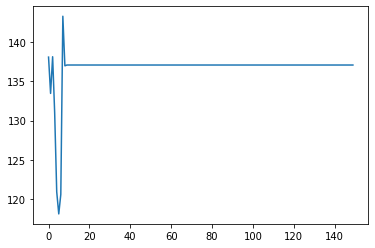

In [89]:
import matplotlib.pyplot as plt
x = [i for i in range(len(loss_stuff))]

plt.plot(x, loss_stuff)

In [100]:
import torch
import torch.nn as nn
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data
import torch
import pandas as pd
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

class CNN(nn.Module):

    def __init__(self, in_channels=1, num_classes=4):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(2,2), stride=(1,1), padding=(1,1))
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride= (2,2))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=64, kernel_size=(2,2), stride=(1,1),padding=(1,1))
        self.fc1 = nn.Linear(576, num_classes)

    def forward(self, x):
        # print("Forrrward!!!!")
        # print("Input", x.shape)

        x = F.relu(self.conv1(x))
        # print("After first conv ",x.shape)
        x = self.pool(x)
        # print("after 1 pooling", x.shape)

        x = F.relu(self.conv2(x))
        # print("after 2 convolution layer",x.shape)
        x = self.pool(x)
        # print("after 2 poolling",x.shape)
        x = x.reshape(x.shape[0], -1)
        # print("after flatten",x.shape)
        x = self.fc1(x)
        # print("after fully connected layer",x.shape)
        x = F.log_softmax(x, dim=1)
        # print("after softmax",x.shape)

        return x

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=576, out_features=4, bias=True)
)

In [168]:
# from kfoldCNN.CNN import CNN
#
# model = CNN()
# path = r"C:\Users\sofu0\OneDrive - ITU\Bachelor\kfold\fold0\sub_folder0\CNN_super-robin"
#
# model.load_state_dict(torch.load(path))
# # model.eval()

ModuleNotFoundError: No module named 'CNN'

In [1]:
print("lol")

lol


<h2> Plot loss function

In [43]:
import json

# C:\Users\sofu0\OneDrive - ITU\Bachelor\kfold\fold2\sub_folder0
# ADAM-LSTM_super_robin_stats10-05-2021LSTMMorten

path = r"C:\Users\sofu0\OneDrive - ITU\Bachelor\kfold\fold2\sub_folder0\ADAM-LSTM_super_robin_stats10-05-2021LSTMMorten.json"
# Opening JSON file
f = open(path)

# returns JSON object as
# a dictionary
data = json.load(f)

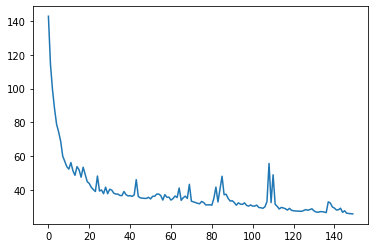

In [45]:
y = data["loss"]
x = [i for i in range(len(y))]
plt.plot(x, y)

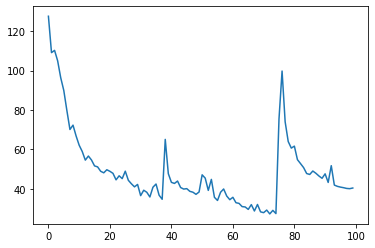

In [56]:
path = r"C:\Users\sofu0\OneDrive - ITU\Bachelor\kfold\fold2\sub_folder3\LSTM_super_robin_stats09-05-2021LSTMMorten.json"
# Opening JSON file
f = open(path)

# returns JSON object as
# a dictionary
data = json.load(f)
y = data["loss"]
x = [i for i in range(len(y))]
plt.plot(x, y)

In [2]:
import pandas as pd
path = r"C:\Users\sofu0\OneDrive - ITU\Bachelor\all_skeleton\all_skeleton_v2.csv"
df = pd.read_csv(path)
good_videos = []
test_videos = []
df

,0x,0y,1x,1y,2x,2y,3x,3y,4x,4y,...,29y,30x,30y,31x,31y,32x,32y,finals,clipname,videoname
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,idle,Video3init,Video1
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,idle,Video3init,Video1
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,idle,Video3init,Video1
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,idle,Video3init,Video1
4,0.238255,0.359316,0.238947,0.349287,0.239765,0.348851,0.240616,0.348537,0.235797,0.349299,...,0.629695,0.223585,0.652335,0.134526,0.638798,0.249388,0.662620,idle,Video3init,Video1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44793,0.524156,0.403692,0.528366,0.382397,0.531561,0.381533,0.534749,0.380650,0.517473,0.383198,...,1.068690,0.512033,1.056539,0.548201,1.130762,0.506130,1.129902,idle,video27init,Video19
44794,0.528549,0.402857,0.533254,0.381566,0.536497,0.380748,0.539910,0.379948,0.522269,0.382231,...,1.065560,0.513997,1.062406,0.551057,1.126227,0.508343,1.128600,idle,video27init,Video19
44795,0.530524,0.402026,0.536087,0.380845,0.539412,0.380139,0.542580,0.379461,0.525124,0.381188,...,1.062724,0.516521,1.058387,0.551389,1.124405,0.508178,1.125588,idle,video27init,Video19
44796,0.533635,0.401251,0.539644,0.380287,0.542915,0.379672,0.546324,0.379101,0.528418,0.380499,...,1.062203,0.515745,1.060971,0.552390,1.122008,0.510948,1.125511,idle,video27init,Video19
